# Classification

## Setup

### Install/import libraries
As usual, remember to use a virtual environment!

### Download data
You can download the EMNIST dataset from the official website. Make sure to provide clear instructions on how to download and extract the data.

### Define helper functions 
It's a good idea to preprocess the data to make it easier to work with. You can create subsets of the data for training, validation, and testing. Also, since the labels in the original dataset are encoded as integers, it may be helpful to create a dictionary that maps the integer labels to their corresponding characters.

## Example: Classify 0 vs 1

### Pre-built models classifying 0/1
 - Logistic regression
 - RandomForest
 - XGBoost
 - Neural network

### Evaluate/compare model performance
 - Confusion matrix: A table that shows the number of true positives, true negatives, false positives, and false negatives for a binary classification problem.
 - Accuracy: The proportion of correct predictions over the total number of predictions.
 - Precision: The proportion of true positives over the total number of positive predictions.
 - Recall: The proportion of true positives over the total number of actual positives.
 - F1 score: The harmonic mean of precision and recall, which balances both metrics and gives equal weight to both.

## Self-guided: Classify digits
DIY baseline model (your choice - logistic regression? decision tree? CNN?) as a starting point. Try out different options, hyperparameters, and feature representations to improve the performance of their classifier. Any opportunity for `feature engineering`?

## Self-guided: Classify all symbols
### Evaluate the model
Evaluate the models on the test set, analyze the confusion matrix to see where the model performs well and where it struggles.

### Investigate subsets
On which classes does the model perform well? Poorly? Evaluate again, excluding easily confused symbols (such as 'O' and '0').

### Improve performance
Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

In [1]:
# Install required packages (once per virtual environment)
%pip install -r ../requirements.txt


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import packages
import os
import string
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import emnist

# ML packages
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
from xgboost import XGBClassifier
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Constants
SIZE = 28
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # or 3 to suppress all warnings


In [3]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Augment images by applying random rotations, translations, and zooms to the original images in the dataset
# Example: randomly select 5 images from the training set and "augment" them by applying random rotations, translations, and zooms
# aug_images, aug_labels = augment_images(train['image'], train['label'], num_aug=5, rot_range=15, trans_range=5, zoom_range=[0.9, 1.1])
def augment_images(images, labels, batch_size):
    """Generate augmented images by applying random rotations, translations, and zooms to the original images in the dataset."""
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
    )
    generator = datagen.flow(
        images,
        labels,
        batch_size=batch_size,
    )
    return generator



In [4]:
# Load data

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
train['image'] = list(image)
train['image_flat'] = train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
valid = pd.DataFrame()
valid['image'] = list(image)
valid['image_flat'] = valid['image'].apply(lambda x: np.array(x).reshape(-1))
valid['label'] = label
valid['class'] = class_label

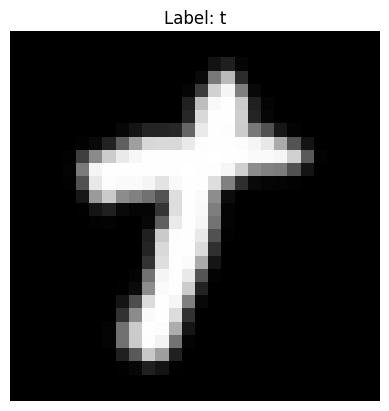

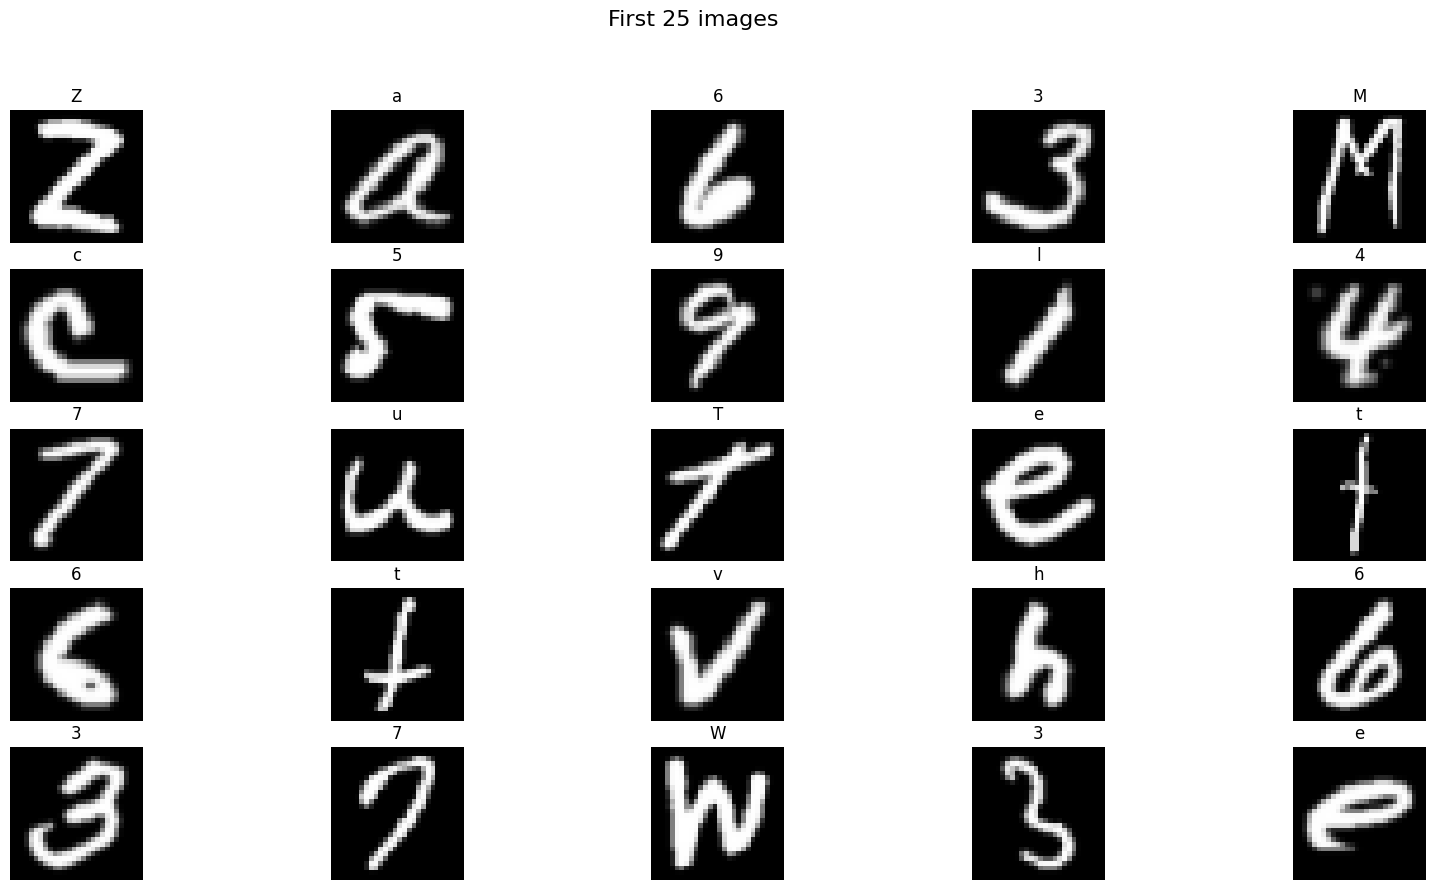

In [5]:
# Using the helper functions

# Plot a random image from the training set
index = np.random.randint(0, len(train))
show_image(train.iloc[index])

# Show a set of 25 images in a 5x5 grid
show_grid(train[:25], title='First 25 images')

# Isn't it nice to have a helper function to do this for you?


In [6]:
# 0 vs 1 Classifier: Subset the data

# Subset `train` and `valid` to only include 0s and 1s
symbols_list = ['0', '1']

mask_train = train['class'].apply(lambda x: x in symbols_list)
train_01 = train[mask_train]
train_01.reset_index(drop=True, inplace=True)

mask_valid = valid['class'].apply(lambda x: x in symbols_list)
valid_01 = valid[mask_valid]
valid_01.reset_index(drop=True, inplace=True)



# Create a dictionary for performance metrics
metrics_dict = {}

# show_grid(train_01[:25], title="First 25 images of 0's and 1's")


In [7]:
# 0 vs 1 Classifier: (optional) We can define all the metrics we want to track in a dictionary
metrics = {
    'task': '0_vs_1',
    'logistic_regression': {
        'confusion_matrix': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    },
    'xgboost': {
        'confusion_matrix': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    },
    'random_forest': {
        'confusion_matrix': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    },
    'neural_network': {
        'confusion_matrix': [],
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1': []
    }
}


In [8]:
# 0 vs 1 Classifier: RandomForest
task = '0_vs_1'
model_name = 'random_forest'

# Initialize random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
rf_clf.fit(train_01['image_flat'].tolist(), train_01['label'])
y_pred = rf_clf.predict(valid_01['image_flat'].tolist())

# Calculate performance metrics
acc = accuracy_score(valid_01['label'], y_pred)
prec = precision_score(valid_01['label'], y_pred)
rec = recall_score(valid_01['label'], y_pred)
f1 = f1_score(valid_01['label'], y_pred)
cm = confusion_matrix(valid_01['label'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task] = {}
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

display(metrics_dict[task][model_name])

{'accuracy': 0.9992566897918731,
 'precision': 0.9987375729840618,
 'recall': 0.9998420221169037,
 'f1': 0.9992894923817794,
 'confusion_matrix': array([[5770,    8],
        [   1, 6329]])}

In [9]:
# 0 vs 1 Classifier: Logistic Regression 
task = '0_vs_1'
model_name = 'logistic_regression'

# Initialize logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Scale the data
# When running without scaling the data, the model does not converge
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_01['image_flat'].tolist())
valid_scaled = scaler.transform(valid_01['image_flat'].tolist())

# Initialize logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Train and evaluate model
lr_clf.fit(train_scaled, train_01['label'])
y_pred = lr_clf.predict(valid_scaled)

# Calculate performance metrics
acc = accuracy_score(valid_01['label'], y_pred)
prec = precision_score(valid_01['label'], y_pred)
rec = recall_score(valid_01['label'], y_pred)
f1 = f1_score(valid_01['label'], y_pred)
cm = confusion_matrix(valid_01['label'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task] = {}
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

display(metrics_dict[task][model_name])


{'accuracy': 0.9972745292368682,
 'precision': 0.9965305156915313,
 'recall': 0.9982622432859399,
 'f1': 0.9973956278115382,
 'confusion_matrix': array([[5756,   22],
        [  11, 6319]])}

In [10]:
# 0 vs 1 Classifier: XGBoost
task = '0_vs_1'
model_name = 'xgboost'

# Initialize XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
xgb_clf.fit(train_01['image_flat'].tolist(), train_01['label'])
y_pred = xgb_clf.predict(valid_01['image_flat'].tolist())

# Calculate performance metrics
acc = accuracy_score(valid_01['label'], y_pred)
prec = precision_score(valid_01['label'], y_pred)
rec = recall_score(valid_01['label'], y_pred)
f1 = f1_score(valid_01['label'], y_pred)
cm = confusion_matrix(valid_01['label'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task] = {}
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

display(metrics_dict[task][model_name])


{'accuracy': 0.9994218698381235,
 'precision': 0.999210484762356,
 'recall': 0.9996840442338073,
 'f1': 0.9994472084024323,
 'confusion_matrix': array([[5773,    5],
        [   2, 6328]])}

In [13]:
# 0 vs 1 Classifier: Neural Network
task = '0_vs_1'
model_name = 'neural_network'

# Set random seed for reproducibility
tf.random.set_seed(42)

# Convert data to tensor
train_images = np.array(train_01['image'])
train_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images)))
train_images = train_images / 255.0
train_labels = np.array(train_01['label'])
valid_images = np.array(valid_01['image'])
valid_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), valid_images)))
valid_images = valid_images / 255.0
valid_labels = np.array(valid_01['label'])

# Initialize neural network model
model = Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(train_images, train_labels, epochs=10, validation_data=(valid_images, valid_labels))

# Evaluate the model
loss, acc = model.evaluate(valid_images, valid_labels)
y_pred = (model.predict(valid_images) > 0.5).astype(int).flatten()

# Calculate performance metrics
prec = precision_score(valid_labels, y_pred)
rec = recall_score(valid_labels, y_pred)
f1 = f1_score(valid_labels, y_pred)
cm = confusion_matrix(valid_labels, y_pred)

# Store performance metrics in dictionary
metrics_dict[task] = {}
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display(metrics_dict[task][model_name])



NameError: name 'test_images' is not defined

In [ ]:
# 0 vs 1 Classifier: Compare models

# Convert metrics_dict to DataFrame
df = pd.DataFrame.from_dict(metrics_dict)

# Transpose the DataFrame to make task names as rows and model names as columns
df = df.T.reset_index()

# Melt the DataFrame to convert the columns into a 'variable' column and a 'value' column
df = pd.melt(df, id_vars=['index'], var_name='model', value_name='metrics')

# Split the metrics column into individual columns
df[['metric', 'value']] = pd.DataFrame(df['metrics'].tolist())

# Create bar plot
sns.barplot(x='index', y='value', hue='metric', data=df, ci=None)
